In [1]:
import urllib
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import openapi

In [2]:
import requests
import pandas as pd

# ✅ API 키 및 URL 설정
s_key = 'l53cN3mbhsudCVoI7zttwvpHkgCTM8on0LpEaT2FZT1/6+weHhppLkhYpjiYtdPL3/h7rqYRcFNBJQCklXUZUQ=='
url = 'http://apis.data.go.kr/B551172/Gastric10/gsLiverByType'

params = {
    'serviceKey': s_key,
    'type': 'json',
    'numOfRows': 100,
    'centerNm': '국립암센터',
    'fromYear': '2010',
    'toYear': '2019',
    'pageNo': 1
}

all_data = []

# 1️⃣ 첫 요청 후 JSON 응답 체크
response = requests.get(url, params=params)

if response.status_code == 200:
    try:
        resp_dict = response.json()
    except ValueError:
        print("❌ JSON 형식 아님 또는 응답이 비어 있음:")
        print(response.text)  # 👉 응답 내용 출력해서 원인 파악
    else:
        total_count = int(resp_dict.get('totalCount', 0))
        items_per_page = params['numOfRows']
        total_pages = (total_count // items_per_page) + (1 if total_count % items_per_page else 0)

        print(f"📌 총 데이터 개수: {total_count}, 가져올 페이지 수: {total_pages}")

        if total_count == 0:
            print("⚠️ 가져올 데이터가 없습니다.")
        else:
            for i in range(1, total_pages + 1):
                page_params = params.copy()
                page_params['pageNo'] = i

                page_response = requests.get(url, params=page_params)

                if page_response.status_code == 200:
                    try:
                        page_data = page_response.json()
                        items = page_data.get('items', [])
                        all_data.extend(items)
                        print(f"📄 페이지 {i}/{total_pages} 처리 완료! (누적 {len(all_data)}개)")
                    except ValueError:
                        print(f"❌ 페이지 {i}의 응답이 JSON이 아님:")
                        print(page_response.text)
                else:
                    print(f"❌ 페이지 {i} 요청 실패 - 상태 코드 {page_response.status_code}")

        print(f"✅ 총 {len(all_data)}개의 데이터 수집 완료!")

else:
    print(f"❌ 첫 요청 실패 - 상태 코드: {response.status_code}")

# ✅ 데이터프레임으로 변환
df_liver = pd.DataFrame(all_data)

📌 총 데이터 개수: 941, 가져올 페이지 수: 10
📄 페이지 1/10 처리 완료! (누적 100개)
📄 페이지 2/10 처리 완료! (누적 200개)
📄 페이지 3/10 처리 완료! (누적 300개)
📄 페이지 4/10 처리 완료! (누적 400개)
📄 페이지 5/10 처리 완료! (누적 500개)
📄 페이지 6/10 처리 완료! (누적 600개)
📄 페이지 7/10 처리 완료! (누적 700개)
📄 페이지 8/10 처리 완료! (누적 800개)
📄 페이지 9/10 처리 완료! (누적 900개)
📄 페이지 10/10 처리 완료! (누적 941개)
✅ 총 941개의 데이터 수집 완료!


In [3]:
df_liver = df_liver.iloc[:, [1,2,3,4,5,-2]]

In [4]:
df_liver.rename(columns={'centerNm':'센터 이름', 'critYr':'기준 년도', 'statsTrgtNm':'고혈압 병력 여부', 'ptAge':'연령' ,'ptSexCd':'성별', 'statsTrgtNm':'간질환 발병 이력 여부', 'ptCntNmvl': '환자수'}, inplace=True)
df_liver

,센터 이름,기준 년도,연령,성별,간질환 발병 이력 여부,환자수
0,국립암센터,2011,36,F,N,2
1,국립암센터,2018,60,M,N,9
2,국립암센터,2019,60,M,N,4
3,국립암센터,2011,79,M,N,5
4,국립암센터,2018,49,F,N,1
...,...,...,...,...,...,...
936,국립암센터,2012,69,F,N,2
937,국립암센터,2010,83,F,N,1
938,국립암센터,2018,47,M,N,1
939,국립암센터,2015,65,F,N,1


In [7]:
df_liver['환자수'] = pd.to_numeric(df_liver['환자수'], errors='coerce')

df_liver['환자수'] = df_liver['환자수'].fillna(0).astype(int)

liver_count = df_liver.groupby(df_liver['간질환 발병 이력 여부'].fillna('무응답'))['환자수'].sum()

print(liver_count)

간질환 발병 이력 여부
N      2385
Y        64
무응답      35
Name: 환자수, dtype: int64


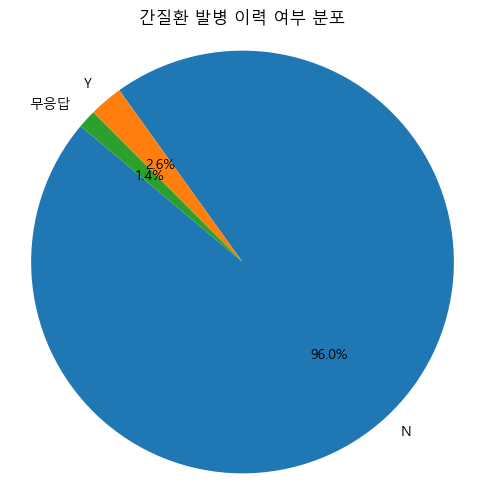

In [8]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(liver_count.values, labels=liver_count.index, autopct='%1.1f%%', startangle=140)
plt.title('간질환 발병 이력 여부 분포')
plt.axis('equal')
plt.show()